# Results of quantile regression on all of the sample

In [1]:
#%% Modules
###############################################################################
import pandas as pd                                     ## Dataframes
import numpy as np                                      ## Numeric methods
import statsmodels as sm                                ## Statistical models
import statsmodels.formula.api as smf                   ## Formulas
import time
from sklearn.preprocessing import scale 

In [2]:
class QuantileReg(object):
    """ 
    Fit a conditional regression model, via quantile regressions

    Inputs:
    - depvar: string, dependent variable 
    - indvars: list of independent variables
    - quantile_list: list of quantiles to run the fit on
    - data = data to train the model on
    - scaling: zscore of the variables: standardized coefficients
    - alpha: the level of confidence to compute the confidence intervals
    
    Output:
    - qfit_dict = regressions fit, per quantiles (statsmodels object)
    - mfit = OLS regression fit, for the conditional mean
    - coeff = coefficients of the quantile regression, for every quantile
    - cond_quant: conditional quantiles and mean 

    Usage:
    qr = QuantileReg('y_growth_fwd_4', indvars=p_indvars, quantile_list=ql,
                     data=df, scaling=True, alpha=0.2)

    """
    __description = "Conditional quantiles, based on quantile regressions"
    __author = "Romain Lafarguette, IMF/MCM, rlafarguette@imf.org"

    ## Initializer
    def __init__(self, depvar, indvars, quantile_list, data, scaling=True,
                 alpha=0.1):

        ## Parameters
        self.scaling = scaling
        self.alpha = alpha
        self.quantile_list = quantile_list
        
        ## Variables
        self.depvar = depvar

        ## Data cleaning for the regression
        self.data = data.dropna()


        ## All data
        
        ## List of regressors
        self.regressors = [x for x in indvars if x in self.data.columns]

        ## Formula regression
        self.reg_formula = self.__reg_formula()
        
        ## Depending on user input, scale the variables
        vars_reg = [self.depvar] + self.regressors
        if self.scaling == True:
            self.data.loc[:, vars_reg] = scale(self.data.loc[:, vars_reg])
        else:
            pass
        
        ## From class methods (see below)
        self.qfit_dict = self.__qfit_dict()
        self.mfit = self.__mfit()
        self.coeff = self.__coeff()

        ## Conditional quantiles: use as predictors the historical regressors
        ## Basically, in-sample prediction but can be customized
        self.cond_quant = self.cond_quantiles(predictors=data)
        
    ## Methods
    def __reg_formula(self):
        """ Specify the formula for the quantile regressions """
        regressors_l = self.regressors[0]
        for v in self.regressors[1:]: regressors_l += ' + {0}'.format(v)
        reg_f = '{0} ~ {1}'.format(self.depvar, regressors_l)
        return(reg_f)

    def __qfit_dict(self): 
        """ Estimate the fit for every quantiles """
        qfit_dict = dict()
        for tau in self.quantile_list:
            reg_f = self.reg_formula
            qfit = smf.quantreg(formula=reg_f, data=self.data).fit(q=tau,
                                                                   maxiter=2000,
                                                                   p_tol=1e-05)


            qfit_dict[tau] = qfit
        return(qfit_dict)

    def __mfit(self): 
        """ Estimate the fit for every quantiles """
        mfit = smf.ols(self.reg_formula, data=self.data).fit()
        return(mfit)
    
    def __coeff(self):
        """ Extract the parameters and package them into pandas dataframe """
        params = pd.DataFrame()
        for tau in self.quantile_list:
            qfit = self.qfit_dict[tau]
            stats = [qfit.params,qfit.pvalues,qfit.conf_int(alpha=self.alpha)]
            stats_names = ['coeff', 'pval', 'lower', 'upper']
            dp = pd.concat(stats, axis=1); dp.columns = stats_names
            dp.insert(0, 'quantile', qfit.q) # Insert as a first column
            dp['R2_in_sample'] = qfit.prsquared
            #dp = dp.loc[dp.index != 'Intercept',:].copy()
            ## Add the scaling information
            dp.loc[:,'normalized'] = self.scaling
            params = pd.concat([params, dp], axis=0) #params = params.append(dp)
        
        ## For information,  coeffs from an OLS regression (conditional mean)
        mfit = self.mfit
        stats = [mfit.params, mfit.pvalues, mfit.conf_int(alpha=self.alpha)]
        stats_names = ['coeff', 'pval', 'lower', 'upper']
        dmp = pd.concat(stats, axis=1); dmp.columns = stats_names
        dmp.insert(0, 'quantile', 'mean') # Insert as a first column
        dmp['R2_in_sample'] = mfit.rsquared
        #dmp = dmp.loc[dmp.index != 'Intercept',:].copy()
        ## Add the scaling information
        dmp.loc[:,'normalized'] = self.scaling
        coeff = pd.concat([params, dmp], axis='index')
        
        ## Return the full frame
        return(coeff)
    
    def cond_quantiles(self, predictors):
        """ 
        Estimate the conditional quantiles in sample 
        - Predictors have to be a pandas dataframe with regressors as columns
        """
        cond_quantiles = pd.DataFrame()
                
        for tau in self.quantile_list:
            qfit = self.qfit_dict[tau]
            # Run the prediction over a predictors frame     
            dc = qfit.get_prediction(exog=predictors).summary_frame()
            dc.columns = ['conditional_quantile_' + x for x in dc.columns]    
            ## Insert extra information            
            dc.insert(0, 'tau', tau)
            dc = dc.set_index(predictors.index)
            dc.insert(1, 'realized_value', predictors.loc[:, self.depvar])    
            cond_quantiles = pd.concat([cond_quantiles, dc], axis=0) #cond_quantiles = cond_quantiles.append(dc)  
                        
        ## Add the conditional mean
        dm = self.mfit.get_prediction(exog=predictors).summary_frame()
        dm.columns = ['conditional_quantile_' + x for x in dm.columns]    
        dm.insert(0, 'tau', 'mean')
        dm = dm.set_index(predictors.index)

        ## Insert the realized value (depvar is y(t+h))
        dm.insert(1, 'realized_value', predictors.loc[:, self.depvar])
        
        ## Concatenate both frames
        cq = pd.concat([cond_quantiles, dm])

        return(cq)

In [3]:
FCI = pd.read_csv(r'C:\Users\jadfa\OneDrive\Documents\GitHub\GaR-1\GAR\partition\Data\FCIdataall.csv')
FCI['Date'] = pd.date_range(start='2004-01-31', end='2021-08-31', freq='M')
FCI.set_index('Date', inplace=True)
FCI.drop(['date'], axis=1, inplace=True)

In [4]:
FCI

,external,macrodomestic,priceofrisk,ratepressure
Date,,,,
2004-01-31,-2.207338,1.533725,-0.823581,-0.555556
2004-02-29,-2.171729,1.299080,-0.710737,-0.776415
2004-03-31,-2.003386,2.167055,-0.577655,-0.049595
2004-04-30,-1.870378,1.832301,-0.332216,-0.279369
2004-05-31,-1.645444,2.380172,-0.352025,-1.184848
...,...,...,...,...
2021-04-30,0.394652,2.122346,6.162592,2.744152
2021-05-31,0.563938,2.559607,6.491272,2.767487
2021-06-30,0.840628,1.711975,6.658384,4.146759


In [5]:
all = pd.read_csv(r'C:\Users\jadfa\OneDrive\Documents\GitHub\GaRIMF\GAR\partition\data\alldatanonscaled.csv')
all['Date'] = pd.date_range(start='2004-01-31', end='2021-08-31', freq='M')
all.set_index('Date', inplace=True)
all.drop(['Unnamed: 0'], axis=1, inplace=True)

In [6]:
gdpdf = pd.concat([all['gdp'], all['gdp3'], all['gdp6'], all['gdp12']], axis = 1)
gdpdf

,gdp,gdp3,gdp6,gdp12
Date,,,,
2004-01-31,0.075949,0.084416,0.076923,0.023529
2004-02-29,0.143791,0.100000,0.088608,-0.080000
2004-03-31,0.133803,0.097403,0.082803,0.031056
2004-04-30,0.084416,0.076923,0.055556,0.005988
2004-05-31,0.100000,0.088608,0.071429,0.042424
...,...,...,...,...
2021-04-30,-0.168605,0.026316,-0.224242,-0.209790
2021-05-31,-0.067485,-0.076389,-0.237805,-0.092105
2021-06-30,0.065359,-0.189873,-0.281609,-0.202454


In [7]:
#Scale gdp 
gdp_s = scale(gdpdf)
gdp_s = pd.DataFrame(gdp_s, columns=['gdp_s', 'gdp3_s', 'gdp6_s', 'gdp12_s'])
gdp_s['Date'] = pd.date_range(start='2004-01-31', end='2021-08-31', freq='M')
gdp_s.set_index('Date', inplace=True)
gdp_s

,gdp_s,gdp3_s,gdp6_s,gdp12_s
Date,,,,
2004-01-31,0.478835,0.567536,0.536852,0.200672
2004-02-29,0.976814,0.680291,0.620043,-0.524133
2004-03-31,0.903498,0.661498,0.578712,0.253364
2004-04-30,0.540980,0.513328,0.384720,0.077865
2004-05-31,0.655375,0.597866,0.497733,0.332954
...,...,...,...,...
2021-04-30,-1.316272,0.147180,-1.607374,-1.432789
2021-05-31,-0.574018,-0.595895,-1.703935,-0.608882
2021-06-30,0.401102,-1.416963,-2.015811,-1.381428


In [8]:
df = pd.concat([FCI, gdp_s['gdp_s'], gdp_s['gdp12_s'], all['Dummy_variable2006']], axis=1)

In [9]:
df

,external,macrodomestic,priceofrisk,ratepressure,gdp_s,gdp12_s,Dummy_variable2006
Date,,,,,,,
2004-01-31,-2.207338,1.533725,-0.823581,-0.555556,0.478835,0.200672,0
2004-02-29,-2.171729,1.299080,-0.710737,-0.776415,0.976814,-0.524133,0
2004-03-31,-2.003386,2.167055,-0.577655,-0.049595,0.903498,0.253364,0
2004-04-30,-1.870378,1.832301,-0.332216,-0.279369,0.540980,0.077865,0
2004-05-31,-1.645444,2.380172,-0.352025,-1.184848,0.655375,0.332954,0
...,...,...,...,...,...,...,...
2021-04-30,0.394652,2.122346,6.162592,2.744152,-1.316272,-1.432789,0
2021-05-31,0.563938,2.559607,6.491272,2.767487,-0.574018,-0.608882,0
2021-06-30,0.840628,1.711975,6.658384,4.146759,0.401102,-1.381428,0


<Axes: xlabel='Date'>

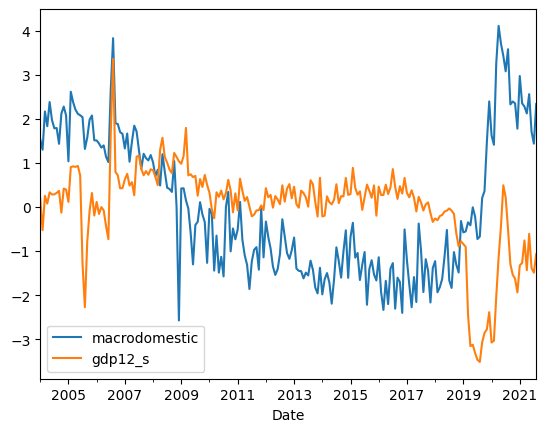

In [10]:
df[['macrodomestic', 'gdp12_s']].plot()

In [11]:
indvars = df[['external','priceofrisk', 'macrodomestic', 'gdp_s', 'ratepressure', 'Dummy_variable2006']] #'priceofrisk', 

In [12]:
indvars

,external,priceofrisk,macrodomestic,gdp_s,ratepressure,Dummy_variable2006
Date,,,,,,
2004-01-31,-2.207338,-0.823581,1.533725,0.478835,-0.555556,0
2004-02-29,-2.171729,-0.710737,1.299080,0.976814,-0.776415,0
2004-03-31,-2.003386,-0.577655,2.167055,0.903498,-0.049595,0
2004-04-30,-1.870378,-0.332216,1.832301,0.540980,-0.279369,0
2004-05-31,-1.645444,-0.352025,2.380172,0.655375,-1.184848,0
...,...,...,...,...,...,...
2021-04-30,0.394652,6.162592,2.122346,-1.316272,2.744152,0
2021-05-31,0.563938,6.491272,2.559607,-0.574018,2.767487,0
2021-06-30,0.840628,6.658384,1.711975,0.401102,4.146759,0


In [13]:
ql = [0.05, 0.1, 0.5, 0.7, 0.9]

In [14]:
Qresult = QuantileReg('gdp12_s', indvars=indvars , quantile_list=ql, data=df, scaling=True, alpha=0.2)

In [15]:
Qresult.coeff

,quantile,coeff,pval,lower,upper,R2_in_sample,normalized
Intercept,0.05,-1.285936e+00,3.907910e-43,-1.379391,-1.192480,0.470961,True
external,0.05,-1.651883e-01,1.734276e-02,-0.253724,-0.076653,0.470961,True
priceofrisk,0.05,8.901683e-01,8.920110e-09,0.699348,1.080988,0.470961,True
macrodomestic,0.05,-9.258854e-02,3.206570e-01,-0.212165,0.026988,0.470961,True
gdp_s,0.05,3.985313e-02,7.188421e-01,-0.102279,0.181985,0.470961,True
ratepressure,0.05,-1.327493e+00,1.588821e-28,-1.458945,-1.196042,0.470961,True
Dummy_variable2006,0.05,4.018562e-01,6.403297e-35,0.367487,0.436226,0.470961,True
Intercept,0.1,-9.583495e-01,7.714466e-37,-1.037086,-0.879613,0.437212,True
external,0.1,-2.238866e-02,6.960158e-01,-0.095960,0.051182,0.437212,True
priceofrisk,0.1,8.549774e-01,7.543998e-12,0.703722,1.006233,0.437212,True


# Ploting

In [16]:
#import os, sys, importlib                             ## Operating system
import pandas as pd                                   ## Dataframes
import numpy as np                                    ## Numeric tools
import matplotlib.pyplot as plt                       ## Plotting
import seaborn as sns                                 ## Plotting
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter

In [17]:
#%% Plotting
###############################################################################
## Style of the charts
plt.style.use('seaborn-white')

## Charting parameters : size
from pylab import rcParams
plt.close('all')  


C:\Users\jadfa\AppData\Local\Temp\ipykernel_21780\148605903.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [18]:
#%% Coefficients plotting
###############################################################################
def coeff_plot(dcoeffc, regressors, qlist):
    plt.close('all')    
    qlist.sort()
    
    for i in range(len(qlist)):
        if qlist[i]==0.5:
            ind05=i
            break
    qlist.insert(ind05,'mean')
    ## Prepare the coefficient frame
#    dcoeff = frames_dict['Quant reg coefficients']
#    dcoeffc = dcoeff[(dcoeff[group] == group_value)]
#    dcoeffc = dcoeffc.rename(columns={'coeff':'standardized coefficient'}) 
    dcoeffc['errors'] = (dcoeffc['upper'] - dcoeffc['lower'])/2

    ## Variables text
    variable_list_coeff = regressors

    #variable_list_label = {'autoregressive':'Autoregressive',
#                           'prices':'Price of Risk',
#                           'quantities': 'Leverage',
#                           'foreign': 'External'}
    
    ## Define the grid
    n=len(variable_list_coeff)
    fig = plt.figure(figsize=(8*min(4,n+1),6*((n+1)//4+1)+4))
    axes=[]
    gs = GridSpec((n+1)//4+1, min(4,n+1))
    for i in range(n+1):
        axes.append(fig.add_subplot(gs[i//4,i%4]))
    ## Plots    
    
    for v, variable in enumerate(variable_list_coeff):
        vs=variable.split('_trans_')
        varn=vs[0]
        if len(vs) > 4 and vs[1][-4:] != 'None':
                varn += '_' + vs[1]
        if len(varn)>20:
            variable_label = varn[:17]+'...'
        else:
            variable_label = varn
            
        dcv = dcoeffc.loc[dcoeffc.index == variable, :].copy()
        dcv = dcv.reset_index()
        dcv = dcv.set_index(dcv['quantile'])
        dcv = dcv.reindex(qlist)
        erna=dcv['errors'].isnull().any()
            # Plot the coefficients
        if erna:
            dcv['coeff'].plot.bar(color='blue',ax=axes[v])
            x=max(abs(min(dcv['coeff'].values)),abs(max(dcv['coeff'].values)))
        else:
            dcv['coeff'].plot.bar(color='blue',yerr = dcv.errors,ax=axes[v])
            x=max(abs(min(dcv['lower'].values)),abs(max(dcv['upper'].values)))
        axes[v].axhline(y=0, c='black', linewidth=0.7)
        axes[v].set_title('{0}'.format(variable_label), fontsize=25, y=1.05)
        axes[v].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        axes[v].set_xlabel('')
    
        axes[v].set_ylim(-x-0.1,x+0.1)
        axes[v].tick_params(labelsize=25)
        
        # Plot the R2
    dcv['R2_in_sample'].plot.bar(color='blue', ax=axes[n])
    axes[n].set_title('R2: ', fontsize=25, y=1.05)
    axes[n].set_xlabel('')
    axes[n].tick_params(labelsize=25)
    axes[n].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axes[n].set_ylim(0,1)
    fig.subplots_adjust(hspace=0.55, wspace=0.25)   
    fig.suptitle('Quantile regressions coefficients', y=1,fontsize=30)
    #plt.text(-19, 1.40, vars_text, fontsize=22, ha='center')
    # fig.savefig('qfit.png')
    # plt.show()

    return(fig)


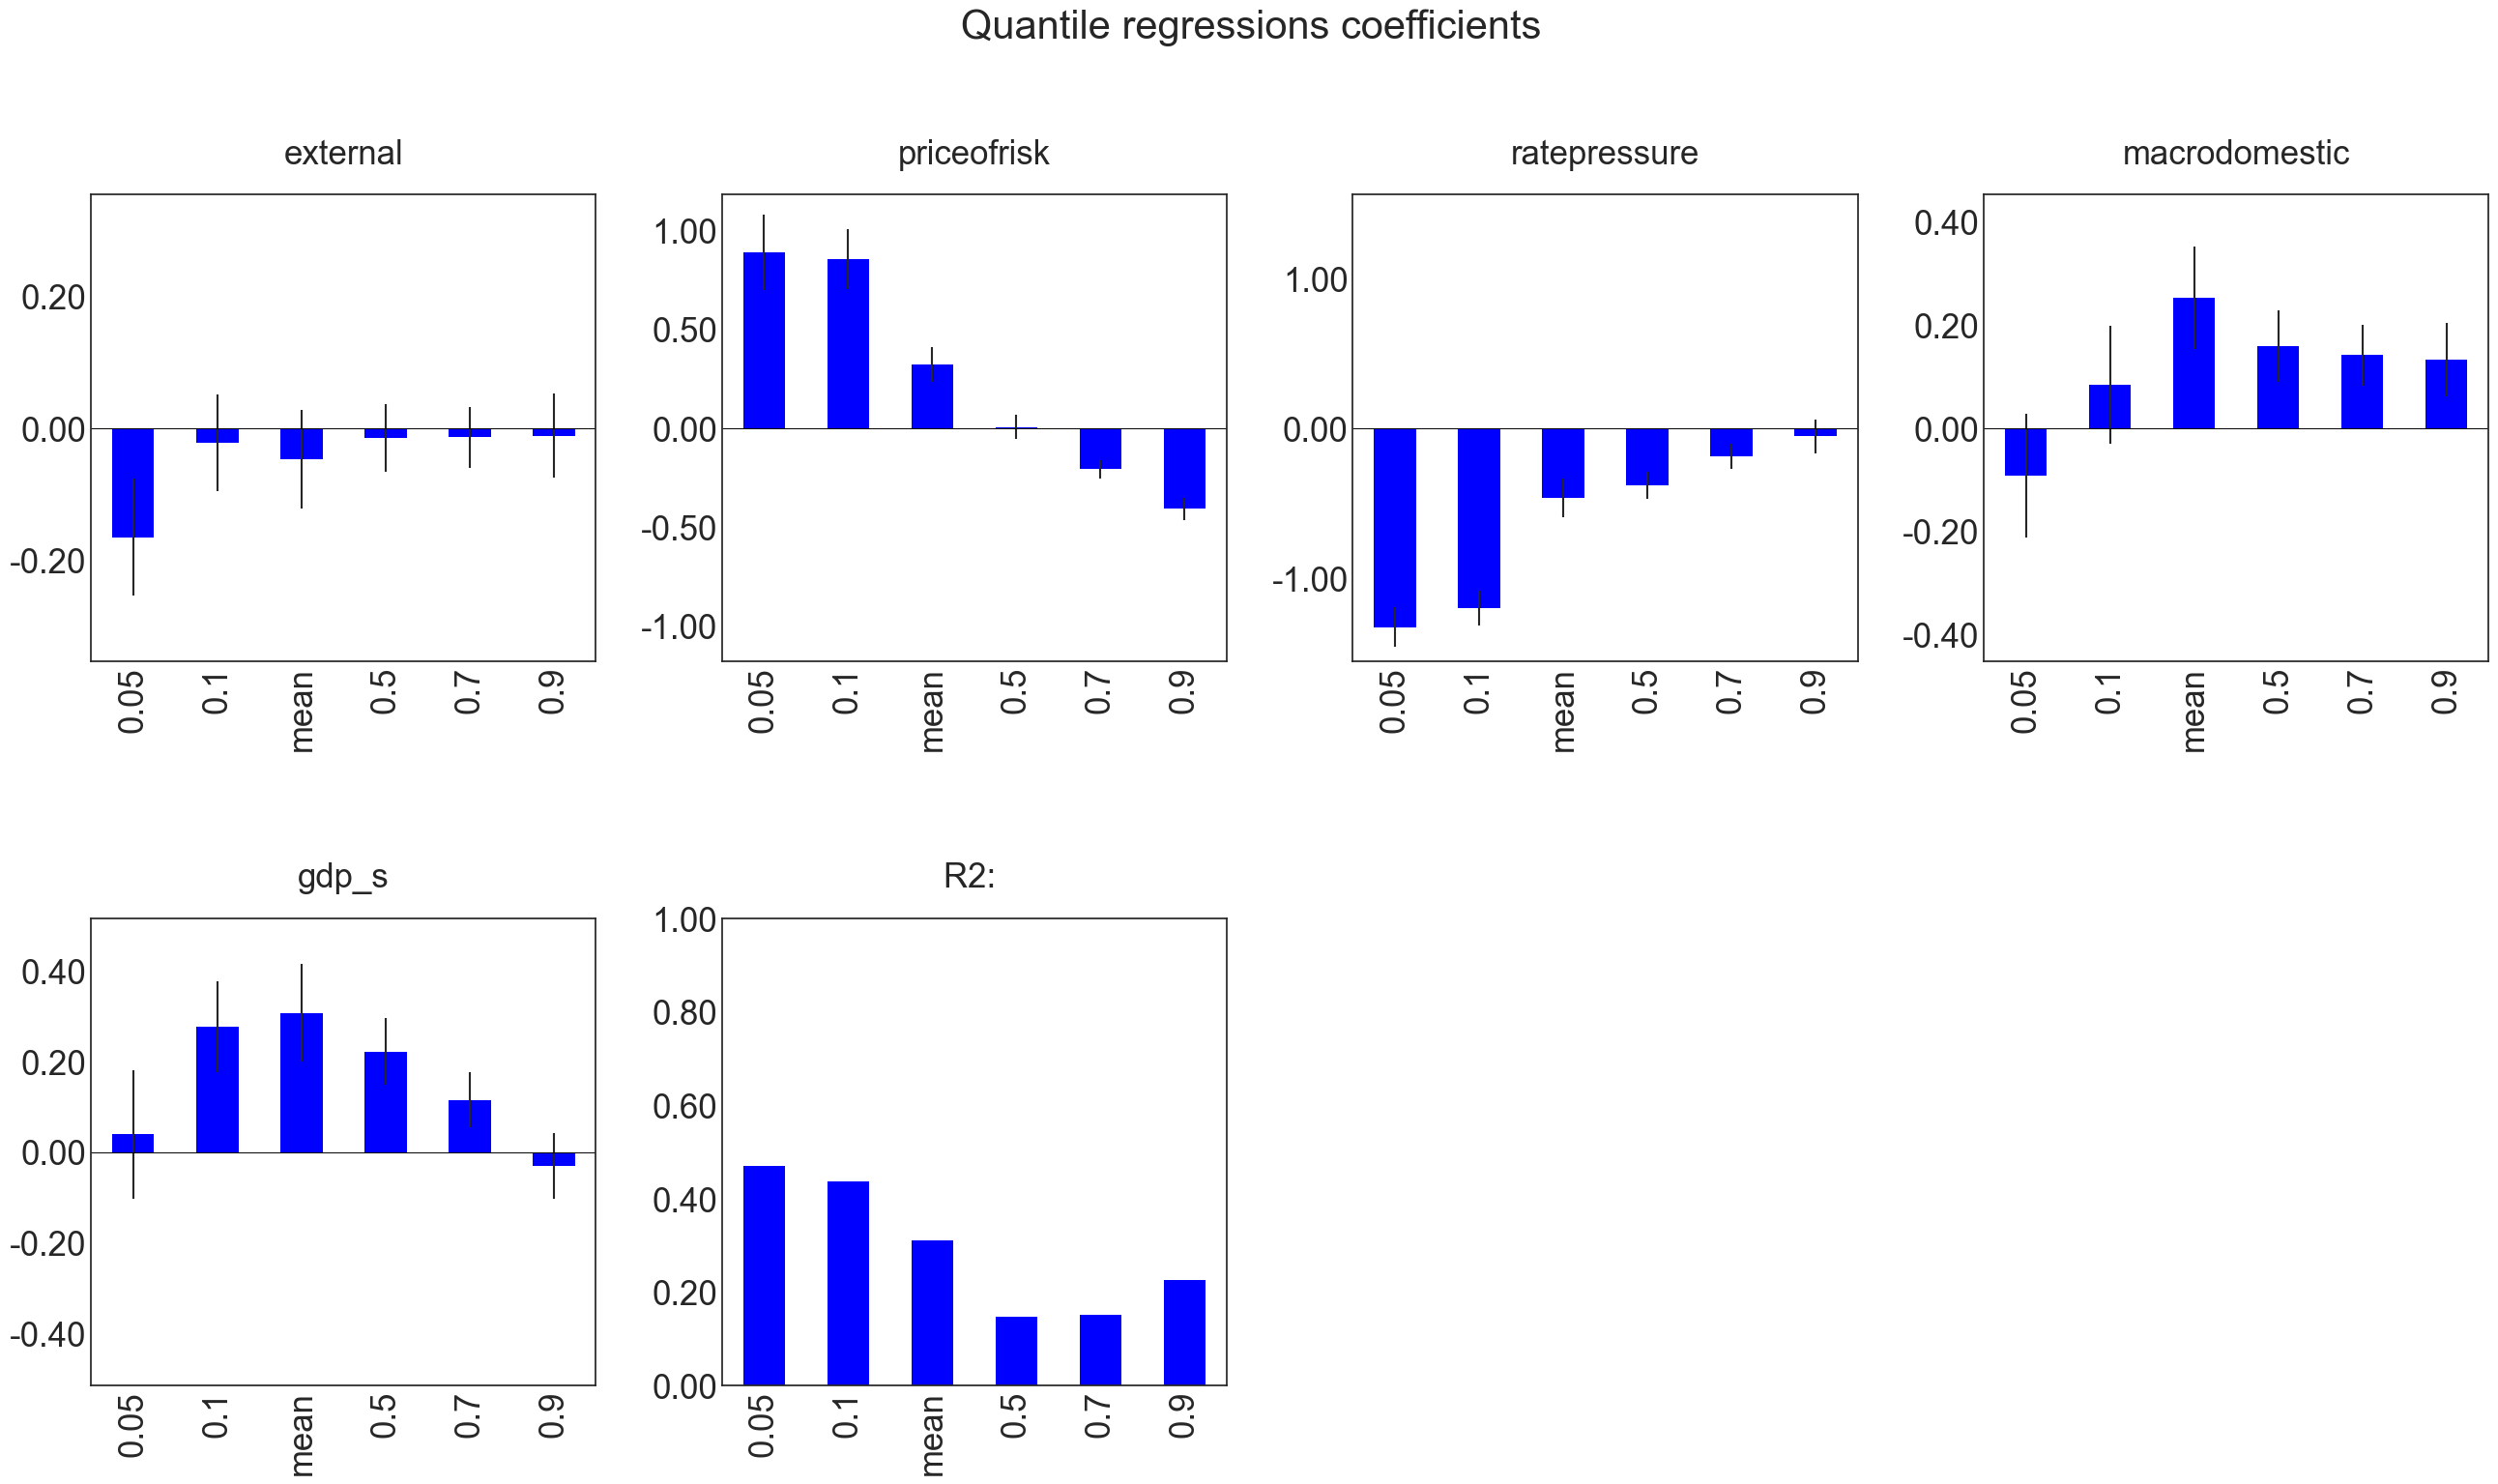

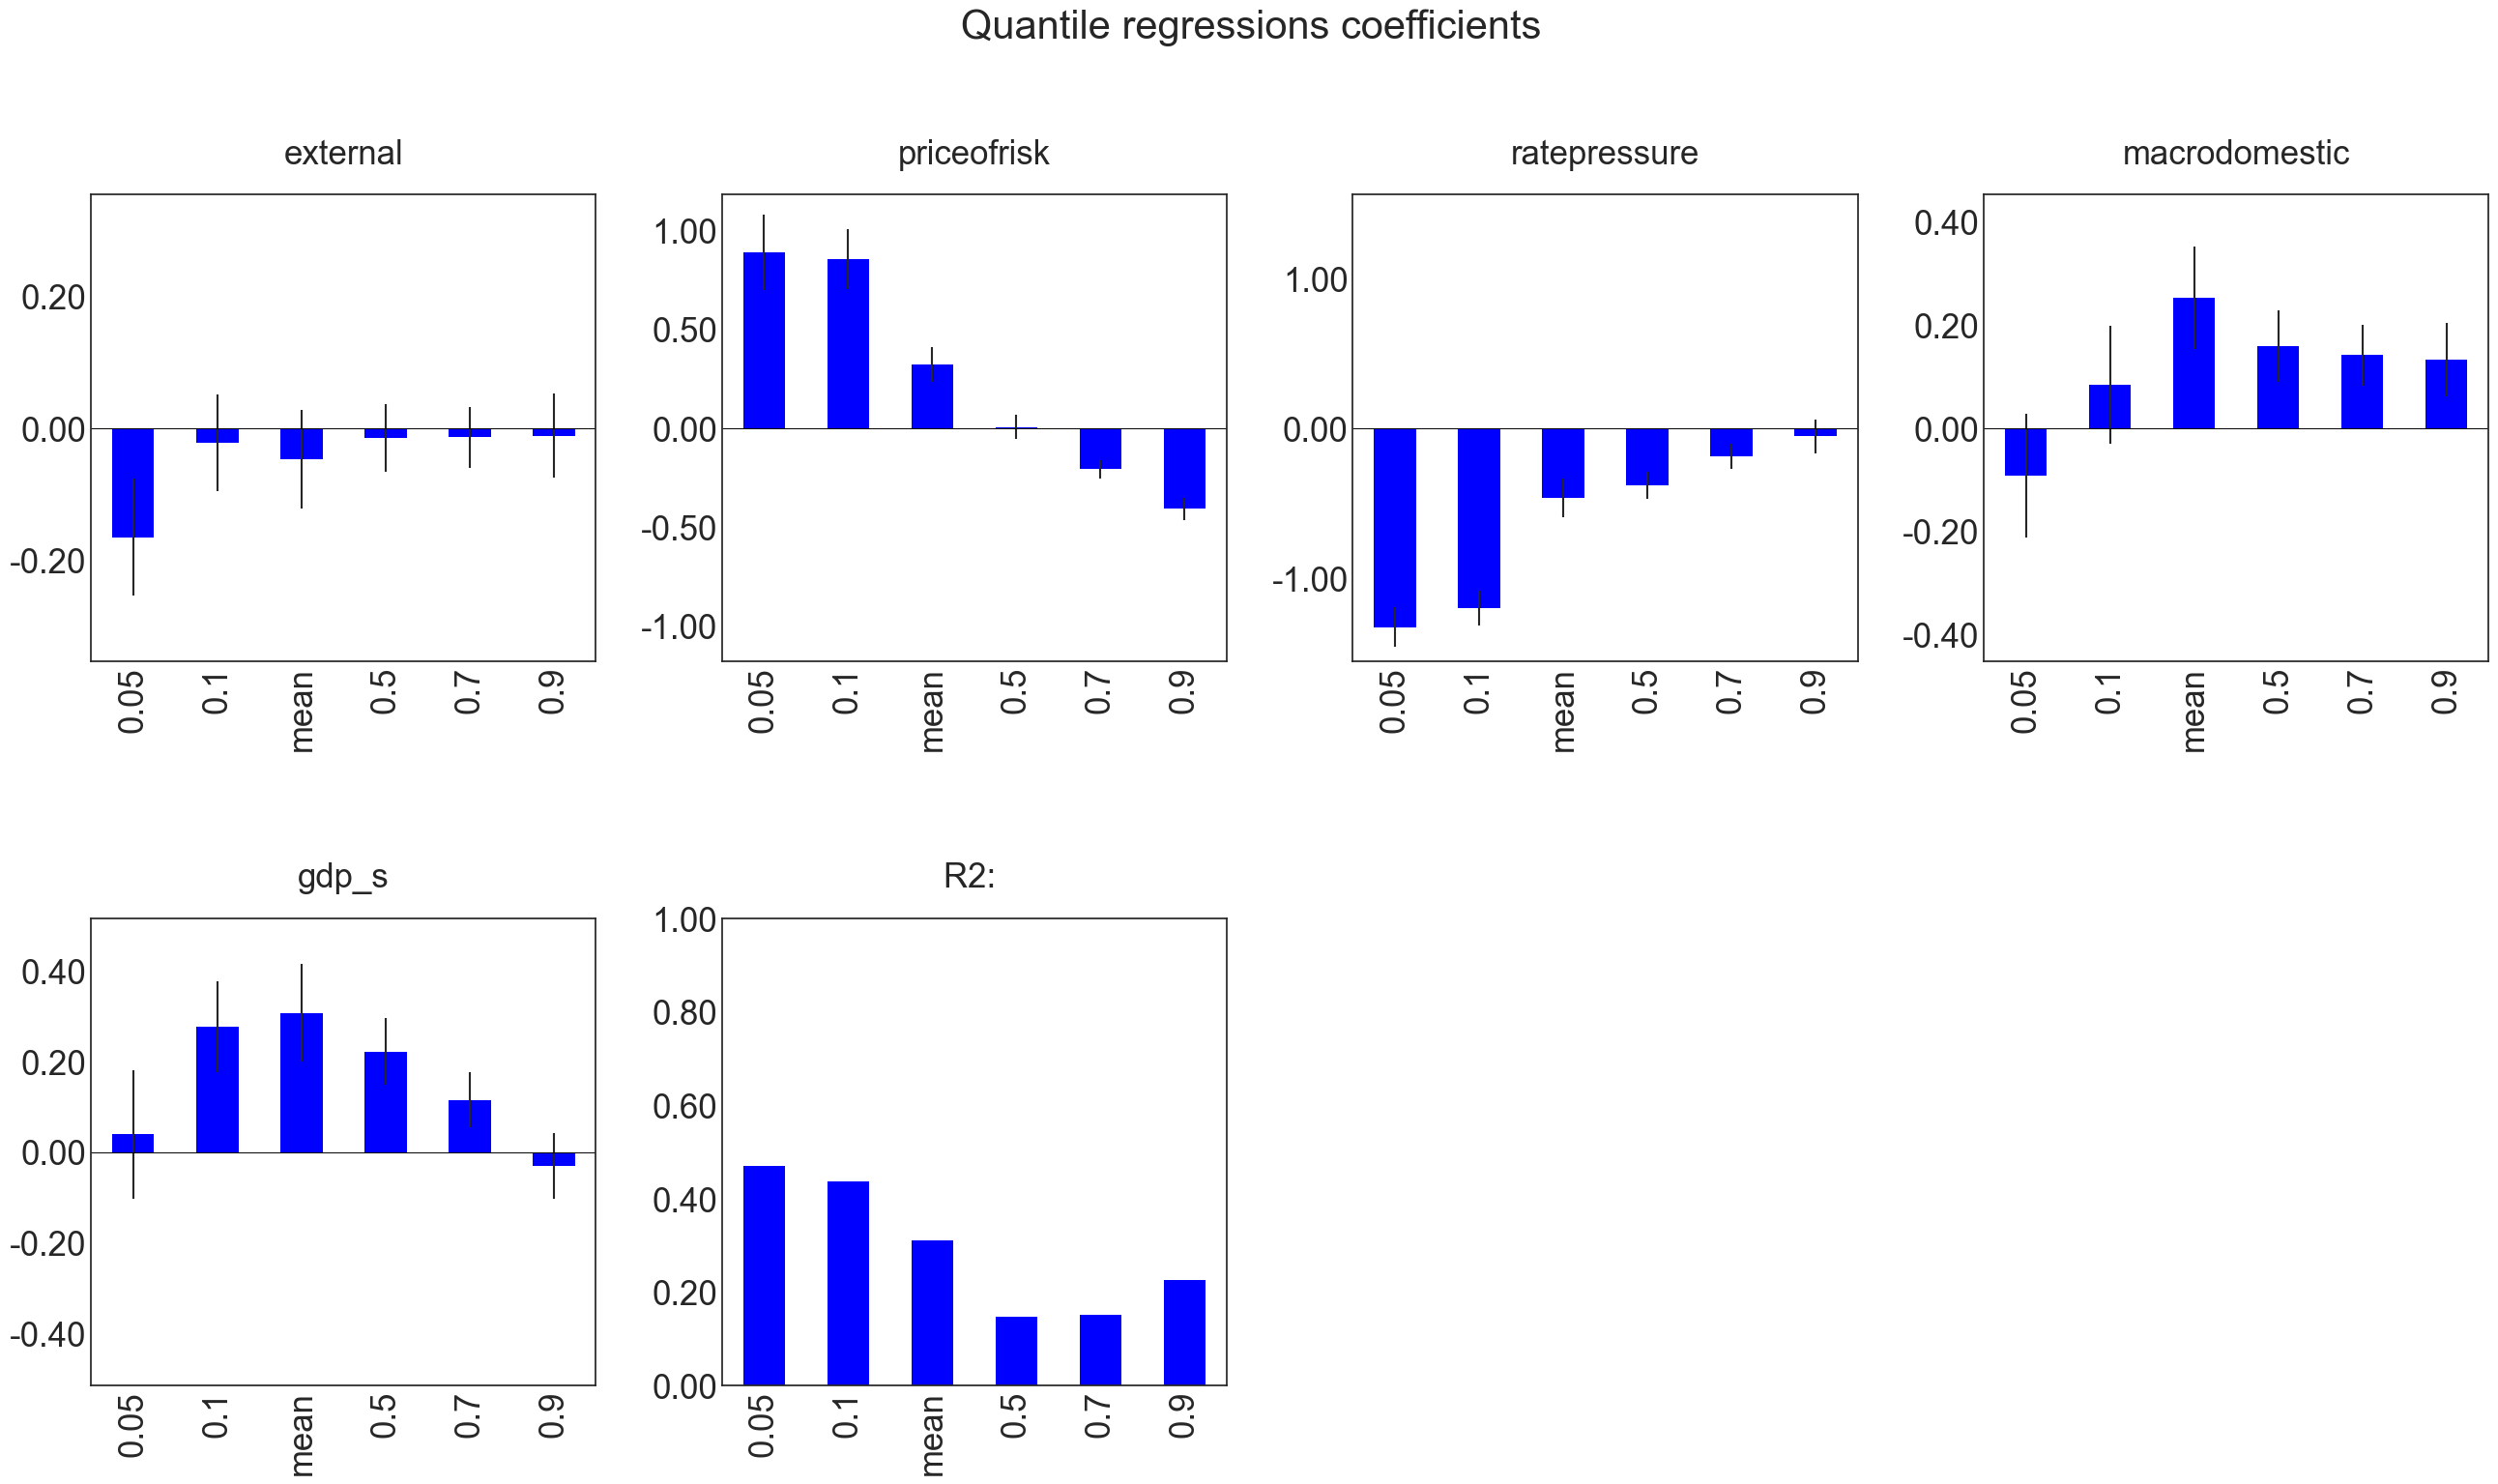

In [19]:
coeff_plot(dcoeffc = Qresult.coeff , regressors = {'external', 'macrodomestic', 'gdp_s', 'priceofrisk', 'ratepressure'}, qlist = [0.05, 0.1, 0.5, 0.7, 0.9])

In [20]:
#Ajmal wehde saraha, only problem is explaining low price of risk post 2019